In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from numba import njit
import pandas as pd

import henon_map_cpp as hm

In [2]:
import henon_map_cpp.dynamic_indicators as di

In [43]:
@njit()
def birkhoff_weights(n_weights):
    # n_weights: number of weights to generate
    # returns: numpy array of weights
    weights = np.zeros(n_weights)
    for i in range(n_weights):
        if i == 0:
            weights[i] = 0.0
        elif i == n_weights - 1:
            weights[i] = 0.0
        else:
            t = i / (n_weights-1)
            weights[i] = np.exp(-np.power(t * (1-t), -1))
    return weights / np.sum(weights)

@njit()
def tune_estimator(x, px):
    """Estimate the tunes with the average phase advanced weighted with Birkhoff weights

    Parameters
    ----------
    x : ndarray
        x-coordinates of the points
    px : ndarray
        px-coordinates of the points

    Returns
    -------
    float
        the weighted average of the phase advances
    """    
    # if any of the points is NaN, return NaN
    if np.isnan(px).any() or np.isnan(x).any():
        return np.nan
    # if any of the points is infinite, return NaN
    if np.isinf(px).any() or np.isinf(x).any():
        return np.nan
    n_samples = len(x)
    # compute weights
    weights = birkhoff_weights(n_samples - 1)
    # make complex numbers
    complex_data = x + 1j * px
    # get angles of all complex numbers
    angles = np.angle(complex_data)
    # compute the phase advance as the difference between consecutive angles
    phase_advances = np.diff(angles)
    # if the phase advance is less than zero, add 2pi to it
    phase_advances[phase_advances < 0] += 2 * np.pi
    # compute the weighted average of the phase advances
    weighted_phase_advances = phase_advances * weights
    average = np.sum(weighted_phase_advances)
    return 1 - average/(2*np.pi)


## Generate some data

In [13]:
side_samples = 50
omega_x = 0.168
omega_y = 0.201
epsilon = 16.0
mu = 0.0
n_turns = 2**10
print("n_turns:", n_turns)

n_samples = side_samples**2

max_extent = 0.7
min_extent = -0.7
x_extents = [max_extent, min_extent]
y_extents = [max_extent, min_extent]
# x_extents = [-0.2, 0.2]
# y_extents = [0.2, 0.5]

x_samples = np.linspace(x_extents[0], x_extents[1], side_samples)
y_samples = np.linspace(y_extents[0], y_extents[1], side_samples)

# make sample grid
x_grid, y_grid = np.meshgrid(x_samples, y_samples)

# make flattened array grid
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

n_turns: 1024


In [14]:
# create the engine
engine = hm.henon_tracker(x_flat, np.zeros_like(x_flat), y_flat, np.zeros_like(y_flat), omega_x, omega_y)

CUDA devices available: 0


In [15]:
engine.reset()

In [40]:
engine.reset()
engine.track(n_turns, epsilon, mu, kick_module=0.0, kick_sigma=0.001)
steps = engine.get_steps()
engine.track(n_turns, epsilon, mu, inverse=True, kick_module=0.0, kick_sigma=0.001)
steps_after = engine.get_steps()

x = engine.get_x()
px = engine.get_px()
y = engine.get_y()
py = engine.get_py()


In [41]:
print("Max steps: ", np.max(steps_after))
print("Min steps: ", np.min(steps_after))

Max steps:  1022
Min steps:  0


In [42]:
x0 = engine.get_x0()
px0 = engine.get_px0()
y0 = engine.get_y0()
py0 = engine.get_py0()

In [43]:
radial_distance = (
    np.sqrt(
        np.power(x - x0, 2) +
        np.power(y - y0, 2) +
        np.power(px - px0, 2) +
        np.power(py - py0, 2)
    )
)

In [44]:
radial_distance


array([nan, nan, nan, ..., nan, nan, nan])

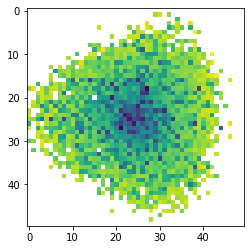

In [45]:
plt.imshow(np.log10(radial_distance).reshape(side_samples, side_samples))

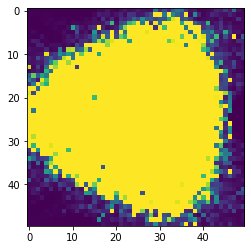

In [46]:
plt.imshow(steps.reshape(side_samples, side_samples))


In [10]:
birkhoff = engine.birkhoff_tunes(n_turns, epsilon, mu, from_idx=np.array([0, 1024]), to_idx=np.array([1024, 2048]))

Computing modulation...
Starting threads...
Returning results...


In [11]:
birkhoff

,from,to,tune_x,tune_y
0,0,1024,"[0.16766481957901136, 0.16783638691255787, 0.1...","[0.20108760860266062, 0.20093245828611772, 0.2..."
1,1024,2048,"[0.16766102645983838, 0.16782144703457413, 0.1...","[0.20101558454937696, 0.20085587615673817, 0.2..."
2,0,16384,"[0.16764451126442903, 0.16782845962936377, 0.1...","[0.2010328020187374, 0.20087157788529453, 0.20..."


In [12]:
birkhoff.iloc[0]["tune_x"]

array([0.16766482, 0.16783639, 0.16803076, ...,        nan,        nan,
              nan])

In [40]:
%matplotlib widget

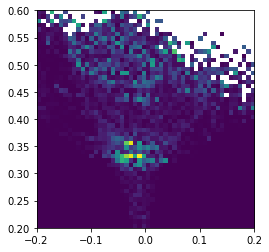

In [16]:
plt.figure()
plt.imshow(np.absolute(birkhoff.iloc[0]["tune_x"] - birkhoff.iloc[1]["tune_x"]).reshape(
    side_samples, side_samples), extent=x_extents + y_extents, origin='lower')


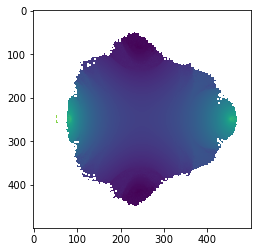

In [28]:
plt.imshow(birkhoff[:,1].reshape(side_samples, side_samples))

In [12]:
np.nanmax(engine.birkhoff_tunes(n_turns, epsilon, mu))

Computing modulation...
Starting threads...
Returning results...


0.4867673965321193

In [10]:
# Pray for the best
x_out, px_out, y_out, py_out = engine.full_track(n_turns, epsilon, mu)

Computing modulation...
Allocating vectors...
Starting threads...
Returning results...


In [42]:
idx = len(x_out) // 3 * 2

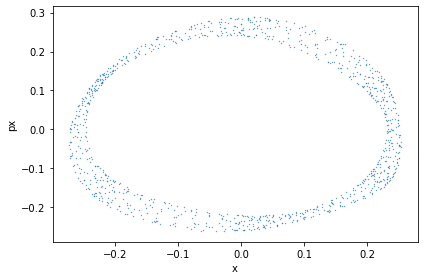

In [43]:
plt.scatter(x_out[idx, :], px_out[idx, :], s=0.1)
plt.xlabel("x")
plt.ylabel("px")

plt.tight_layout()


Text(0, 0.5, 'py')

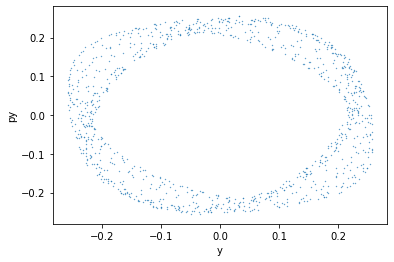

In [44]:
plt.scatter(y_out[idx, :], py_out[idx, :], s=0.1)
plt.xlabel("y")
plt.ylabel("py")


In [45]:
phase_x = np.array([
    tune_estimator(x_out[i, :], px_out[i, :]) for i in range(len(x_out))
])

phase_y = np.array([
    tune_estimator(y_out[i, :], py_out[i, :]) for i in range(len(y_out))
])

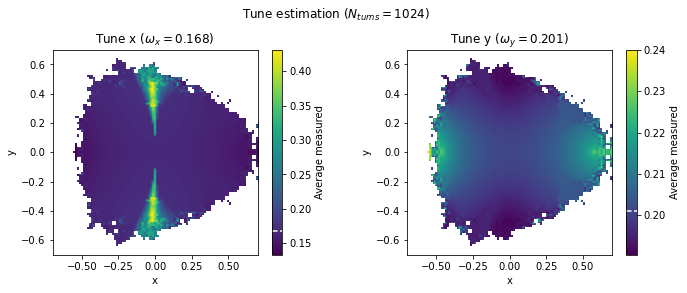

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.imshow(phase_x.reshape(side_samples, side_samples), extent=x_extents + y_extents)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Tune x $(\\omega_x={})$".format(omega_x))
# add colorbar to ax1
cbar = ax1.figure.colorbar(ax1.images[0], ax=ax1, label="Average measured")
cbar.ax.axhline(omega_x, color="white", linestyle="--")

ax2.imshow(phase_y.reshape(side_samples, side_samples), extent=x_extents + y_extents)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Tune y $(\\omega_y={})$".format(omega_y))
# add colorbar to ax2
cbar = ax2.figure.colorbar(ax2.images[0], ax=ax2, label="Average measured")
# plot horizontal line inside the colorbar
cbar.ax.axhline(omega_y, color="white", linestyle="--")

# add a title to both plots
plt.suptitle("Tune estimation $(N_{turns} "+"= {})$".format(n_turns))

plt.tight_layout()
plt.savefig("tune_estimation.jpg", dpi=300)


In [3]:
side_samples = 500
omega_x = 0.168
omega_y = 0.201
epsilon = 32.0
mu = 0.0
n_turns = 2**14
print("n_turns:", n_turns)

n_samples = side_samples**2

max_extent = 0.7
min_extent = -0.7
x_extents = [max_extent, min_extent]
y_extents = [max_extent, min_extent]
# x_extents = [-0.2, 0.2]
# y_extents = [0.2, 0.5]

x_samples = np.linspace(x_extents[0], x_extents[1], side_samples)
y_samples = np.linspace(y_extents[0], y_extents[1], side_samples)

# make sample grid
x_grid, y_grid = np.meshgrid(x_samples, y_samples)

# make flattened array grid
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

n_turns: 16384


In [4]:
my_engine = di.fixed_henon(
    omega_x, omega_y,
    epsilon, mu
)

In [5]:
data = di.fast_lyapunov_indicator(my_engine, x_flat, np.zeros_like(x_flat), y_flat, np.zeros_like(y_flat), n_turns, 1e-6)

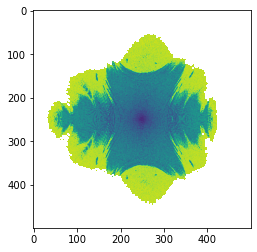

In [6]:
plt.imshow(data.reshape(side_samples, side_samples))

In [7]:
data = di.reversibility_error(my_engine, x_flat, np.zeros_like(
    x_flat), y_flat, np.zeros_like(y_flat), n_turns)


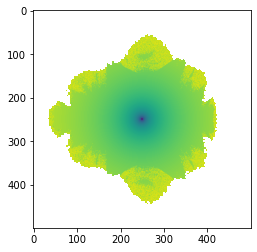

In [8]:
plt.imshow(np.log10(data).reshape(side_samples, side_samples))


In [9]:
data = di.smallest_alignment_index(my_engine, x_flat, np.zeros_like(x_flat), y_flat, np.zeros_like(y_flat), n_turns, 1000, 1e-6)

100%|██████████| 17/17 [00:16<00:00,  1.05it/s]


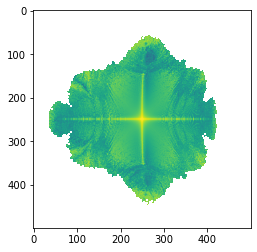

In [10]:
plt.imshow(np.log10(data).reshape(side_samples, side_samples))

In [11]:
data = di.global_alignment_index(my_engine, x_flat, np.zeros_like(x_flat), y_flat, np.zeros_like(y_flat), n_turns, 1000, 1e-6)

100%|██████████| 17/17 [00:37<00:00,  2.19s/it]


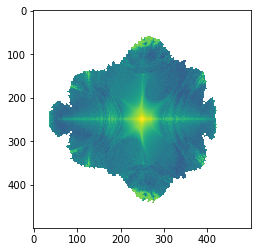

In [12]:
plt.imshow(np.log10(data).reshape(side_samples, side_samples))


In [13]:
n_turns = 10000000

epsilon = 32.0
mu = 0.0
omega_x = 0.168
omega_y = 0.201

n_theta_samples = 250
n_rad_samples = 500
rad_min = 0.3
rad_max = 0.9

theta_samples = np.linspace(0, np.pi/2, n_theta_samples)
rad_samples = np.linspace(rad_min, rad_max, n_rad_samples)

tt, rr = np.meshgrid(theta_samples, rad_samples)

xx, yy = rr*np.cos(tt), rr*np.sin(tt)
x_f = xx.flatten()
y_f = yy.flatten()

In [14]:
engine = hm.henon_tracker(x_f, np.zeros_like(x_f), y_f, np.zeros_like(y_f), omega_x, omega_y)

In [15]:
engine.track(n_turns, epsilon, mu)

In [16]:
steps = engine.get_steps().reshape(n_rad_samples, n_theta_samples)


In [17]:
print(tt.shape)
print(rr.shape)
print(steps.shape)

(500, 250)
(500, 250)
(500, 250)


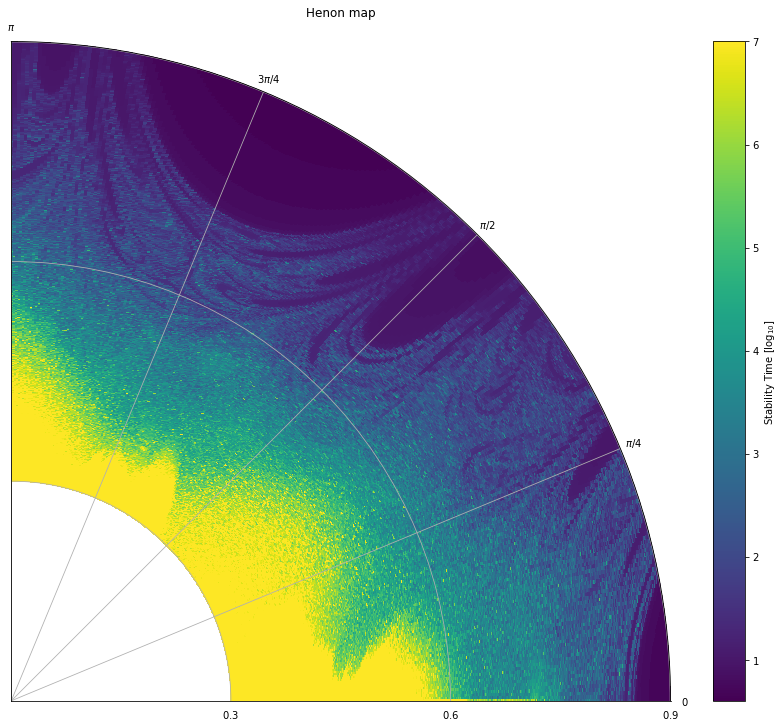

In [20]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection="polar")
mesh = ax.pcolormesh(tt, rr, np.log10(steps), shading="auto")
fig.colorbar(mesh, label="Stability Time $[\\log_{10}]$")

ax.set_thetalim(0, np.pi/2)
ax.grid(True)
# set labels
ax.set_xticks(np.linspace(0, np.pi/2, 5))
ax.set_xticklabels(["$0$", "$\pi/4$", "$\pi/2$", "$3\pi/4$", "$\pi$"])
ax.set_rlabel_position(0)
ax.set_yticks([rad_min, (rad_max + rad_min) / 2, rad_max])
ax.set_yticklabels(
    ["${}$".format(rad_min), "${}$".format((rad_min + rad_max)/2), "${}$".format(rad_max)])

ax.set_title("Henon map")

plt.tight_layout()
